In [179]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Triangulation

## Wie man den Image möglichst vielsagend in schöne Dreiecke zerlegt...

Das Verfahren läuft in drei Schritten:
1. Das Bild wird vorbereitet,
2. Die Dreiecke werden mithilfe einer Self-organizing map (SOM) erzeugt,
3. Ausgabe des Dreiecksbildes.
Details später

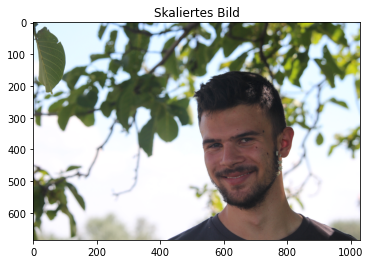

In [241]:
#Import und Skalierung des Bildes
pic_path = "6.jpg" #setze hier dein eingenes Beispielbild ein, optimal HD
img = Image.open(pic_path)
basewidth = 1028
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
img = img.resize((basewidth, hsize), Image.LANCZOS)
plt.imshow(img)
plt.title('Skaliertes Bild')
plt.show()

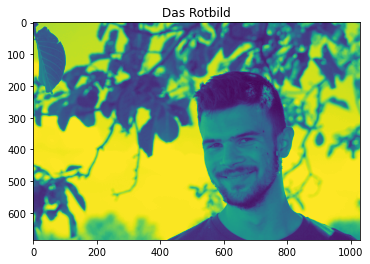

In [242]:
#aufteilung des bildes in rgb schichten
rbg = np.array(img)
r_img = rbg[:,:,0]
g_img = rbg[:,:,1]
b_img = rbg[:,:,2]

plt.imshow(r_img)
plt.title('Das Rotbild')

#die anwendung eines 5*5 filters auf dem bild
def apply_filter(img, A):
    width = len(img[0, :])
    height = len(img[:,0])
    #applying filter
    new_img = np.array([[np.sum(np.multiply(img[i:i+5, j:j+5], A)) for j in range (width-5)] for i in range (height-5)])
    return np.absolute(new_img)/(5**2)

#verkleinerung des bildes um merkmale zu verstärken
def pooling(img):
    #max pooling
    width = len(img[0, :])
    height = len(img[:,0])
    new_img = np.array([[np.max(img[i:i+2, j:j+2]) for j in 2*np.arange(int(np.floor(width/2)))]for i in 2*np.arange(int(np.floor(height/2)))])
    return new_img

Damit der nachfolgende Algorithmus die Dreiecke möglichst effektiv plaziert, ist es wichtig, dass die Merkmale und Muster auf dem Bild deutlich sichtbar sind. Dazu werde ich in jeder Farbschicht vier Filter zur Mustererkennung vertikal, horizontal und diagonal (*2) anwenden. Das Resultat ist der Input für den Hauptalgorithmus.
Eine weitere Möglichkeit Muster zu erkennen wäre, das Bild mit einem konvolutionalen neuronalen Netz vorzubereiten.

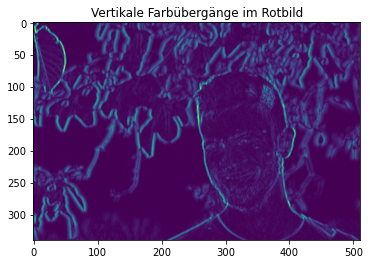

In [243]:
#vertikaler filter
filter_v = np.array([
    [-2, -1, 0, 1, 2],
    [-2, -1, 0, 1, 2],
    [-2, -1, 0, 1, 2],
    [-2, -1, 0, 1, 2],
    [-2, -1, 0, 1, 2]
])

#horizontaler filter
filter_h = np.array([
    [-2,-2,-2,-2,-2],
    [-1,-1,-1,-1,-1],
    [0,0,0,0,0],
    [1,1,1,1,1],
    [2,2,2,2,2]
])

#diagonale filter
filter_d1 = np.array([
    [2, 2, 1, 1, 0],
    [2, 1, 1, 0, -1],
    [1, 1, 0, -1, -1],
    [1, 0, -1, -1, -2],
    [0, -1, -1, -2, -2]
])

filter_d2 = np.array([
    [0, 1, 1, 2, 2],
    [-1, 0, 1, 1, 2],
    [-1, -1, 0, 1, 1],
    [-2, -1, -1, 0, 1],
    [-2, -2, -1, -1, 0]
])

filters = np.array([filter_v,filter_h,filter_d1,filter_d2])

example = pooling(apply_filter(r_img, filter_v))

plt.imshow(example)
plt.title('Vertikale Farbübergänge im Rotbild')
plt.show()

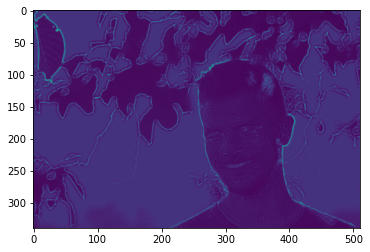

In [244]:
#punktfilter wäre ne idee

filter_p = np.array([
    [-1,-1,-1,-1,-1],
    [-1,1,2,1,-1],
    [-1,2,3,2,-1],
    [-1,1,2,1,-1],
    [-1,-1,-1,-1,-1]
])


filters = np.append(filters, [filter_p], axis = 0)
p = pooling(apply_filter(b_img, filter_p))
plt.imshow(p)
plt.show()

In [282]:
#Addition über die Resultate aller Filter, um eine gesamtheit der kanten zu erhalten
#r_kanten = np.sum(np.array([pooling(apply_filter(r_img, f)) for f in filters]), axis = 0)
print('1.geschafft')
#g_kanten = np.sum(np.array([pooling(apply_filter(g_img, f)) for f in filters]), axis = 0)
print('2.geschafft')
#b_kanten = np.sum(np.array([pooling(apply_filter(b_img, f)) for f in filters]), axis = 0)
print('3.geschafft')
ppp = r_kanten + g_kanten + b_kanten

#ein kleines normalisieren der daten
ppp = np.where(ppp>(4*np.average(ppp)), 4*np.average(ppp), ppp)
ppp /= np.max(ppp)
#ppp ist das foto, dass ich dem Algorithmus eingeben möchte

1.geschafft
2.geschafft
3.geschafft


In [283]:
#unwichtiger aber cooler kram

r_kanten = np.floor(np.where(r_kanten>=255,255,r_kanten)).astype(int)
g_kanten = np.floor(np.where(g_kanten>=255,255,g_kanten)).astype(int)
b_kanten = np.floor(np.where(b_kanten>=255,255,b_kanten)).astype(int)
array = np.zeros((len(g_kanten[:,0]), len(g_kanten[0,:]), 3),dtype=np.uint8)
for i in range (len(g_kanten[:,0])):
    for j in range (len(g_kanten[0,:])):
        array[i,j] = [r_kanten[i,j],g_kanten[i,j],b_kanten[i,j]]
pic = Image.fromarray(array, 'RGB')
#pic.save(r'ali1.png')
pic.show()

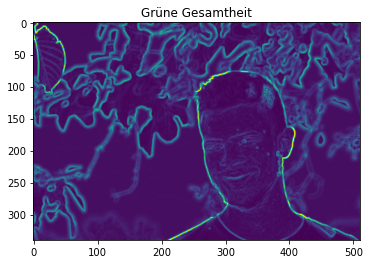

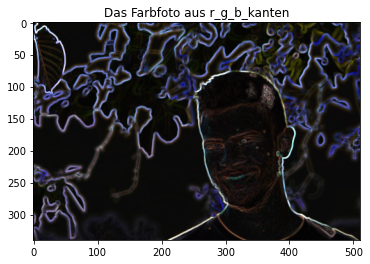

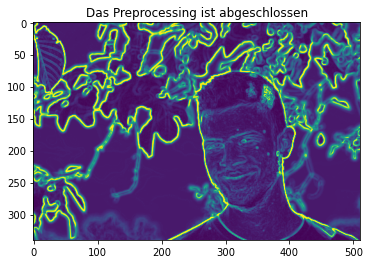

In [247]:
#mögliche Probleme:
#-Starke Farbunterschiedene in uninteressanten Bildbereichen
#-ppp verstärkt nur sowieso starke bereiche
plt.imshow(g_kanten)
plt.title('Grüne Gesamtheit')
plt.show()
new_rgb = np.dstack((r_kanten,g_kanten, b_kanten))/256
plt.imshow(np.where(new_rgb>=1, 1, new_rgb))
plt.title('Das Farbfoto aus r_g_b_kanten')
plt.show()
plt.imshow(ppp)
plt.title('Das Preprocessing ist abgeschlossen')
plt.show()

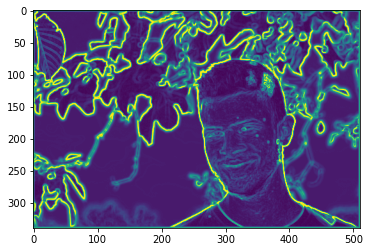

In [286]:
#bizzl rand verstärken
w = len(ppp[0,:])
h = len(ppp[:,0])
ppp[0:2,:]=0.6
ppp[h-2:h,:]=0.6
ppp[:,0:2] = 0.6
ppp[:,w-2:w]=0.6
plt.imshow(ppp)
plt.show()

Nun legen wir eine Self-Organizing-Map auf das Bild. Die Map ist zunächst ein normales Gitter. Die Gitterpunkte wenden sich durch das Training den starken Bildpunkten zu.

In [248]:
#eine funktion zum plotten der som

def plot_som(weights, width, height, image):
    for i in range (height):
        plt.plot(weights[(i*width):(i+1)*width,0], weights[(i*width):(i+1)*width,1], 'ro-' , markersize = 2)
    for j in range (width):
        plt.plot(weights[j:(width*height):width,0], weights[j:(width*height):width,1], 'ro-' , markersize = 2)
    #for j in range (width-1):
        #plt.plot(weights[j:(width*(height+min(0, width-height-j))):width+1,0], weights[j:(width*(height+min(0, width-height-j))):width+1,1], 'ro-' , markersize = 2)
    #for j in range (height-2):
        #plt.plot(weights[(j+1)*width:width*height:width+1,0], weights[(j+1)*width:width*height:width+1,1], 'ro-' , markersize = 2)
    plt.imshow(image)
    plt.xlabel('x-Achse')
    plt.ylabel('y-Achse')
    plt.title('SOM')
    plt.show()

In [249]:
#so verläuft das training der SOM:
#für einen beliebigen Bildpunkt 'point' wird ein 'winner' berechnet, der gitterpunkt, der am nächsten an 'point' 
#liegt. anschließend werden alle gitterpunkte im einem umkreis rad um 'winner' mit einer geschwindigkeit in
#richtung 'point' bewegt, die von lernrate, stärke des bildpunktes und entfernung von 'winner' abhängt.
#die gitterpukte werden vorwieged in richtung starker bildpunkte gezogen und bilden damit einen rahmen für das bild.

def update(weights, width, height, point, strength, rad, learning_rate):
    x,y = get_winner(weights, width, height, point)
    delta_weights = learning_rate*strength*np.array([np.multiply(dist_fct(x,y,i,width,height, rad),(point-weights[i,:]))
                      for i in range (width*height)
               ])
    weights += delta_weights  

def get_winner(weights, width, height, point):
    distances = np.linalg.norm(weights-point, axis = 1)
    min_index = np.argmin(distances)
    return min_index%width, int(np.floor(min_index/width))

def dist_fct(x,y,i, width, height, rad):
    a = i%width
    b = int(np.floor(i/width))
    w = width-1
    h = height-1
    dist = np.abs(a-x)+np.abs(b-y)
    if(dist > rad): 
         return np.array([0,0])
    else:
        #randpunkte sollen nur in eine koordinatenrichtung verschoben werden
        if((b==0)or(b==h)and(a==0)or(a==w)):
            return np.array([0,0])
        elif(b==0)or(b==(h)):
            return np.array([1- dist/rad,0])    
        elif(a==0)or(a==(w)):              
            return np.array([0,1- dist/rad])
        else:
            return (1- dist/rad)*np.ones(2)

In [288]:
def training(picture, weights, width, height, iterations = 500, rad = 5, learning_rate = 0.1):
    for step in range(iterations):
        rad_change = rad/15
        la_change = learning_rate/10
        if((step/iterations *100) % 10 == 0):
            print("Das Training ist zu " + str(step/iterations *100) + "% beendet!")
            rad-= rad_change
            learning_rate -= la_change 
        #draw a random point
        px = random.randint(0,len(picture[0,:])-1)
        py = random.randint(0,len(picture[:,0])-1)
        strength = picture[py,px] #the intensity of the point
        if strength!=0:
            point = np.array([px,py])
            update(weights, width, height, point, strength, rad, learning_rate)
    print("Das Training ist abgeschlossen!")      

(340, 511)


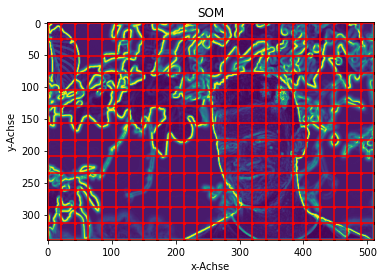

In [287]:
#initialisiere SOM
#die folgenden parameter bestimmen die breite und höhe des gitters und damit die Anzahl der Dreiecke
width =25
height = 14
print(ppp.shape)

#Hier wird das Gitter auf das Bild angepasst
M = np.swapaxes(np.reshape(np.meshgrid(np.linspace(0, len(ppp[0,:]), width), np.linspace(0, len(ppp[:,0]), height)), (2, width*height)),0,1)
plot_som(M, width, height, ppp)

Das Training ist zu 0.0% beendet!
Das Training ist zu 10.0% beendet!
Das Training ist zu 20.0% beendet!
Das Training ist zu 30.0% beendet!
Das Training ist zu 40.0% beendet!
Das Training ist zu 50.0% beendet!
Das Training ist zu 60.0% beendet!
Das Training ist zu 70.0% beendet!
Das Training ist zu 80.0% beendet!
Das Training ist zu 90.0% beendet!
Das Training ist abgeschlossen!


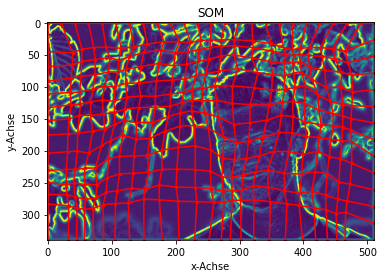

In [289]:
#Das Training beginnt...wir legen die Anzahl der iterationen, Lernrate und den 
#Wirkungsradius der SOM fest

iterations = 220000
radius = 10#int(np.ceil((width*height)**(1/2)))
learning_rate = 0.6

training(ppp, M, width, height, iterations, radius, learning_rate)
plot_som(M, width, height, ppp)

In [264]:
def in_triangle(A, B, C):
    points = []
    s = np.round((A+B+C)/3)
    if (A-s).any() and (B-s).any() and (C-s).any():
        return in_triangle(A,B,s)+in_triangle(A,C,s)+in_triangle(B,C,s)
    else:
        return [A,B,C]

'''def in_triangle(A, B, C):
    X = np
    if ((np.dot(np.array([(B-A)[1],(A-B)[0]]), point -A) > 0) and 
        (np.dot(np.array([(C-B)[1],(B-C)[0]]), point -B) > 0) and 
        (np.dot(np.array([(A-C)[1],(C-A)[0]]), point -C) > 0)) 
        or 
        ((np.dot(np.array([(B-A)[1],(A-B)[0]]), point -A) < 0) and 
         (np.dot(np.array([(C-B)[1],(B-C)[0]]), point -B) < 0) and 
         (np.dot(np.array([(A-C)[1],(C-A)[0]]), point -C) < 0)):'''

def in_triangle(A, B, C):
    X = []
    X.append(A)
    X.append(B)
    X.append(C)
    for x in range (min(int(A[0]), int(B[0]), int(C[0])),max(int(A[0]), int(B[0]), int(C[0]))):
        for y in range (min(int(A[1]), int(B[1]), int(C[1])),max(int(A[1]), int(B[1]), int(C[1]))):
            point = np.array([x,y])
            if (((np.dot(np.array([(B-A)[1],(A-B)[0]]), point -A) >= 0) and (np.dot(np.array([(C-B)[1],(B-C)[0]]), point -B) >= 0) and (np.dot(np.array([(A-C)[1],(C-A)[0]]), point -C) >= 0))
                or ((np.dot(np.array([(B-A)[1],(A-B)[0]]), point -A) <= 0) and (np.dot(np.array([(C-B)[1],(B-C)[0]]), point -B) <= 0) and (np.dot(np.array([(A-C)[1],(C-A)[0]]), point -C) <= 0))):
                X.append(point)
    return np.array(X)
    
    
def gen_picture(weights, picture, width, height):
    data = 255*np.ones((len(picture[:,0])+1, len(picture[0,:]+1)+1, 3), dtype= np.uint8)
    for i in range (width-1):
        print('You are in line ' + str(i) + ' from ' + str(width-2))
        for j in range (height-1):
            s = np.floor((weights[j*width+i]+ weights[j*width+i+1]+ weights[(j+1)*width+i+1])/3)
            color = picture[int(s[1]), int(s[0])]
            for x in in_triangle(weights[j*width+i], weights[j*width+i+1], weights[(j+1)*width+i+1]):
                data[int(x[1]),int(x[0])]= color
            s = np.floor((weights[j*width+i]+ weights[(j+1)*width+i]+ weights[(j+1)*width+i+1])/3)
            color = picture[int(s[1]),int(s[0])]
            for x in in_triangle(weights[j*width+i], weights[(j+1)*width+i], weights[(j+1)*width+i+1]):
                data[int(x[1]),int(x[0])]= color
    return data

In [290]:
#das ursprugsbild auf die gleiche größe wie die SOM bringen
basewidth = 511
wpercent = (basewidth / float(img.size[0]))
hsize = int((float(img.size[1]) * float(wpercent)))
imgs = img.resize((basewidth, hsize), Image.LANCZOS)
rgbs = np.array(imgs)

In [291]:
#so jetzt die gewichte auf ganze zahlen bringen
M = np.floor(M)
tryang = gen_picture(M, rgbs, width, height)

You are in line 0 from 23
You are in line 1 from 23
You are in line 2 from 23
You are in line 3 from 23
You are in line 4 from 23
You are in line 5 from 23
You are in line 6 from 23
You are in line 7 from 23
You are in line 8 from 23
You are in line 9 from 23
You are in line 10 from 23
You are in line 11 from 23
You are in line 12 from 23
You are in line 13 from 23
You are in line 14 from 23
You are in line 15 from 23
You are in line 16 from 23
You are in line 17 from 23
You are in line 18 from 23
You are in line 19 from 23
You are in line 20 from 23
You are in line 21 from 23
You are in line 22 from 23
You are in line 23 from 23


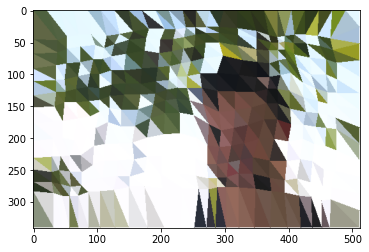

In [292]:
plt.imshow(tryang)
pic = Image.fromarray(tryang, 'RGB')
pic.save(r'tryyourbest.png')

In [17]:
# ----------------------------------------------------------------------------------------------------
# Self Organizing Map 
# Idee - unüberwachtes Lernen - Pixel Punkt Zuordnung - basierend darauf Dreiecke bilden
# ----------------------------------------------------------------------------------------------------
def sgn(x):
    if(x < 0):
        return -1
    else: 
        return 1

# ----------------------------------------------------------------------------------------------------
# NN - Klasse
# Soll Gewichte Speichern und sich trainieren lassen

class SOM(object):

    def __init__(self, pic_path, fineness):
        
        self.pic_width, self.pic_height = im.size
        self.pic_width = int(self.pic_width) -1
        self.pic_height = int(self.pic_height) -1
        self.rgb_pic = im.convert('RGB')
        X = np.round(np.linspace(0,self.pic_width -1, fineness))
        Y = np.round(np.linspace(0,self.pic_height -1 , fineness))
        self.weights = np.array([[[x,y,self.rgb_pic.getpixel((x, y))[0],self.rgb_pic.getpixel((x, y))[1],self.rgb_pic.getpixel((x, y))[2]] for x in X] for y in Y] )
        self.fineness = fineness


    def in_triangle(self, point, A, B, C):
        return ((np.dot(np.array([(B-A)[1],(A-B)[0]]), point -A) > 0) and (np.dot(np.array([(C-B)[1],(B-C)[0]]), point -B) > 0) and (np.dot(np.array([(A-C)[1],(C-A)[0]]), point -C) > 0)) or ((np.dot(np.array([(B-A)[1],(A-B)[0]]), point -A) < 0) and (np.dot(np.array([(C-B)[1],(B-C)[0]]), point -B) < 0) and (np.dot(np.array([(A-C)[1],(C-A)[0]]), point -C) < 0)) 

    def get_color(self, point):
        for i in range(self.fineness -2):
            j = 0
            if(self.in_triangle(point, np.array([self.weights[i][j][0],self.weights[i][j][1]]), np.array([self.weights[i][j+1][0],self.weights[i][j+1][1]]), np.array([self.weights[i+1][j][0],self.weights[i+1][j][1]]))):
                return (self.weights[i][j][2],self.weights[i][j][3],self.weights[i][j][4])
            j = self.fineness -2
            if(self.in_triangle(point,  np.array([self.weights[i][j][0],self.weights[i][j][1]]), np.array([self.weights[i+1][j][0],self.weights[i+1][j][1]]) , np.array([self.weights[i+1][j-1][0],self.weights[i+1][j-1][1]]))):
                return (self.weights[i][j][2],self.weights[i][j][3],self.weights[i][j][4])
            for j in range(1,self.fineness -2):
                if(self.in_triangle(point, np.array([self.weights[i][j][0],self.weights[i][j][1]]), np.array([self.weights[i][j+1][0],self.weights[i][j+1][1]]), np.array([self.weights[i+1][j][0],self.weights[i+1][j][1]])) or self.in_triangle(point,  np.array([self.weights[i][j][0],self.weights[i][j][1]]), np.array([self.weights[i+1][j][0],self.weights[i+1][j][1]]) , np.array([self.weights[i+1][j-1][0],self.weights[i+1][j-1][1]]))):
                    return (self.weights[i][j][2],self.weights[i][j][3],self.weights[i][j][4])
        return (0,0,0)

    def gen_image(self):
        data = np.zeros((self.pic_height, self.pic_width, 3), dtype= np.uint8)
        for x in range(self.pic_height -1):
            for y in range(self.pic_width -1):
                data[x][y] = self.get_color(np.array([y,x]))
            if(x/(self.pic_height-1) * 100 % 10 == 0):
                print("Das Bild ist zu " + str(x/(self.pic_height-1) * 100) + "% generiert! ")
        pic = Image.fromarray(data, 'RGB')
        pic.save('my_pic.png')
        pic.show()

    def get_dist(self, A, B):
        dist = abs(A[0] - B[0]) + abs(A[1]-B[1]) 
        temp = min(abs(B[0]-A[0]), abs(B[1]-A[1]))
        dist = dist - 0.5 * abs(sgn(B[0]-A[0]) * temp - sgn(B[1]-A[1])* temp)
        return dist

    def get_winner(self, point):
        distances = np.linalg.norm(self.weights-point, axis = 2)
        min_index = np.argmin(distances)
        return (int(np.floor(min_index/self.fineness)),min_index%self.fineness)
        
    def dist_fct(self, dist, rad):
        if(dist > rad): 
            return 0
        else:
            return 1- dist/rad

    def training(self, max_iteration, learn_rate):
        rad = 3
        max_iteration = 2000#max_iteration * self.pic_height * self.pic_width
        for step in range(max_iteration):
            if((step/max_iteration *100) % 10 == 0):
                print("Das Training ist zu " + str(step/ max_iteration *100) + "% beendet!")
            x = random.randint(0,self.pic_height -1)
            y = random.randint(0, self.pic_width -1)
            r,g,b = self.rgb_pic.getpixel((y,x))
            point = np.array([y,x,r,g,b])
            k,l = self.get_winner(point)
            self.weights += [[learn_rate*self.dist_fct(self.get_dist([l,k],[i,j]), rad)* (point-self.weights[i][j][:]) for i in range (self.fineness)]for j in range (self.fineness)]
            rad = rad * 0.99
        print("Das Training ist abgeschlossen!")
            


# ----------------------------------------------------------------------------------------------------
# Test



# ----------------------------------------------------------------------------------------------------
# Bild ist im gleichen Verzeichnis, wie das Python Programm
pic_path = "6.jpg"

NN = SOM(pic_path, 20)
print(NN.pic_height)
NN.training(5, 0.1)
NN.gen_image()

NameError: name 'im' is not defined